# Find A Raster Tile

**Goal**: Find the raster tile your pit falls in.

**Approach**: 
1. Grab the pit location from the a pit layer in the database
2. Perform an interest on all raster tiles with the pit location 
3. Convert the raster to tiff 
4. Dump to memory and plot 


Grabbing rasters that overlap on the point POINT (745458 4322762)


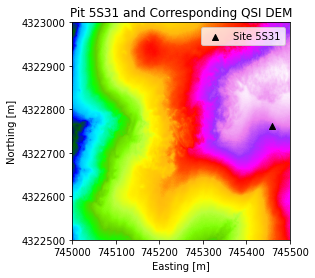

In [1]:
from snowxsql.db import get_db
from snowxsql.data import ImageData, LayerData
from rasterio.plot import show
from sqlalchemy.sql import func
import geoalchemy2.functions as gfunc
from geoalchemy2.shape import to_shape
from rasterio import MemoryFile
import matplotlib.pyplot as plt
import geopandas as gpd
from snowxsql.conversions import raster_to_rasterio

# PIT Site Identifier
site_id = '5S31'

# Connect to the database we made.
db_name = 'snowex'
engine, session = get_db(db_name)
datasets = []

# Grab our pit layers by site id
q = session.query(LayerData).filter(LayerData.site_id == site_id)
layers = q.all()

# Grab the pit location from a single layer
p = layers[0].geom
p_shp = to_shape(p)

print('Grabbing rasters that overlap on the point {}'.format(p_shp))
rasters = session.query(func.ST_AsTiff(ImageData.raster)).filter(gfunc.ST_Intersects(ImageData.raster, p)).all()

fig,ax = plt.subplots()
ax.ticklabel_format(style='plain', useOffset=False)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Pit {} and Corresponding QSI DEM'.format(site_id))
datasets = raster_to_rasterio(session, rasters)
show(datasets[0].read(1), ax=ax, transform=datasets[0].transform, cmap='gist_ncar')

gpd.GeoSeries(p_shp).plot(ax=ax, color='k', marker='^', label="Site {}".format(site_id))
ax.legend()
for d in datasets:
    d.close()

